### LangGraph

LangGraph es una biblioteca del ecosistema LangChain diseñada para construir flujos de trabajo complejos y colaborativos entre múltiples agentes de IA. Utiliza una arquitectura basada en grafos, donde cada nodo puede ser un agente o una función, y las conexiones (aristas) definen el flujo y la comunicación entre ellos.

Esto permite crear sistemas donde varios agentes pueden interactuar, compartir información y tomar decisiones de manera coordinada, con soporte para memoria y control de estado. LangGraph es útil para aplicaciones como asistentes inteligentes, agentes autónomos, sistemas de decisión y automatización avanzada, facilitando la orquestación y escalabilidad de soluciones basadas en IA.

### Elementos de LangGraph

* **Graph**: En LangGraph, un "Graph" (grafo) es la estructura principal que modela el flujo de trabajo de agentes como un conjunto de nodos (Nodes) conectados por aristas (Edges). Permite definir rutas, ciclos y la lógica de transición entre agentes o funciones, facilitando la coordinación y ejecución de sistemas complejos multiagente.

* **State**: El "State" (estado) es una estructura de datos compartida que representa una instantánea actual de la aplicación. Contiene toda la información relevante que se va actualizando conforme los nodos procesan datos y toman decisiones. Puede ser un diccionario de Python, un TypedDict o un modelo Pydantic, y es fundamental para mantener el contexto a lo largo de la ejecución del grafo.   El estado en LangGraph es inmutable. Asociado a cada campo del estado, se puede definir un `reducer`. LangGraph usa el `reducer` de cada campo para combinarlo con el estado actual.

* **Node**: Un "Node" (nodo) en LangGraph es típicamente una función de Python que implementa la lógica de un agente o un paso del flujo de trabajo. Recibe el estado actual como entrada, realiza un procesamiento o acción, y devuelve un estado actualizado.

* **Edge**: Una "Edge" (arista) es una función o conexión que determina qué nodo se ejecuta a continuación, en función del estado actual. Las aristas pueden ser transiciones fijas o condicionales, y permiten definir flujos de trabajo complejos, incluyendo bifurcaciones y ciclos. Son responsables de guiar el paso de información y la secuencia de ejecución entre nodos.


### Pasos para definir un grafo

 1. **Definir el estado**: Crear una clase que represente el estado compartido de la aplicación, utilizando un diccionario, TypedDict o Pydantic.
 2. Empezar el `graph buiilder` para crear un nuevo grafo.
 3. Crear un nodo.
 4. Crear Edges.
 5. Compilar el grafo

### Ejemplo de uso



In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel
import random


In [3]:
# Algunas constantes útiles

nouns = ["Coles", "Unicornios", "Tostadoras", "Pingüinos", "Plátanos", "Zombis", "Arcoíris", "Anguilas", "Pepinillos", "Muffins"]
adjectives = ["escandaloso", "maloliente", "pedante", "existencial", "malhumorado", "brillante", "poco fiable", "sarcástico", "blandito", "embrujado"]


In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [ ]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### Hola Mundo LangGraph

Vamos a hacer un ejemplo sencillo para comprender todos los pasos necesarios para crear un grafo en LangGraph. Este ejemplo demuestra que LangGraph sirve para construir flujos de trabajo que no requieren de un LLM. 

**Paso 1: Definir el estado**

El estado, en este caso, va a ser una clase de tipo `Pydantic` que contendrá un campo `messages`. El tipo de `messages` será una lista. Una forma alternativa a definir `type hint`, es usar campos "anotados". Los tipos anotados normalmente incluyen un comentario y son ignorados por Python, pero pueden ser usados en otro contexto. En este caso, LangGraph permite que definir el `reducer` de tipo. En este caso es una función ya proporcionada por LangGraph.


In [6]:
class State(BaseModel):
        
    messages: Annotated[list, add_messages]


**Paso 2: Iniciar el `graph builder`**

In [16]:
graph_builder = StateGraph(State)

**Paso 3: Crear un nodo**

In [17]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

**Crear Edges**

In [18]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

**Compilar el grafo**

In [19]:
graph = graph_builder.compile()

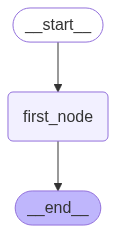

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

**Probamos**

In [13]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content



In [20]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hola', additional_kwargs={}, response_metadata={}, id='1256c93d-5479-4172-a3be-6b92935cb9a6'), AIMessage(content='Unicornios malhumorado', additional_kwargs={}, response_metadata={}, id='6d90f519-c752-4e64-89ce-d0c2b5555273')]}
{'messages': [HumanMessage(content='j', additional_kwargs={}, response_metadata={}, id='4bbf0350-9fdd-4b5f-aed6-3dbfa9d9660d'), AIMessage(content='Tostadoras pedante', additional_kwargs={}, response_metadata={}, id='0909e583-8689-492c-ba3b-fc84e14f0d2b')]}
{'messages': [HumanMessage(content='kk', additional_kwargs={}, response_metadata={}, id='6d55b6df-7134-4027-a142-d9c2b2114549'), AIMessage(content='Tostadoras existencial', additional_kwargs={}, response_metadata={}, id='472bbf98-aea4-45ad-8a17-bce05496a44f')]}


### Uso de LLMs en 

En este ejercicio incorporamos un LLM para que el grafo pueda interactuar con un modelo de lenguaje.

In [21]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [22]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [23]:
# Step 3: Create a Node

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [24]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

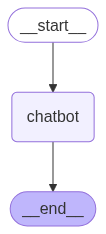

In [ ]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def chat(user_input: str, history):
    initial_state = State(messages=history + [{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

{'messages': [HumanMessage(content='Tú no eres Pepe', additional_kwargs={}, response_metadata={}, id='f9c2e0d5-0a7c-4b69-a7d2-9e711ec66434'), AIMessage(content='Como un modelo de lenguaje grande, no tengo nombre ni identidad fija. No soy Pepe ni ninguna otra persona. Soy una inteligencia artificial.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--0b7ba62e-e25f-4bc8-a861-305c984c298c-0', usage_metadata={'input_tokens': 4, 'output_tokens': 28, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}
* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hola', additional_kwargs={}, response_metadata={}, id='414c8376-4655-4d59-b072-68ec94ffeaa0'), AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy? 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--26b9a4a4-e169-4a56-8c9f-7c128caf64f4-0', usage_metadata={'input_tokens': 1, 'output_tokens': 12, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='Hola', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='fd39de88-d436-4053-8b7a-d1beda43e057'), AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy? 😊', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='26fba296-1ee8-4dc6-b265-906e505a0671'), HumanMessage(content='QUiero llamarte Luna. Debes contestar sólo cuando me dirija a ti con tu nombre. Si no menc

### Tools y LangSmith
En este ejercicio vamos a aprender a usar `tools`. Además configuraremos la herramienta de `tracing` de LangSmith. Para poder depurar y analizar el grafo. LangSmith es una herramienta del ecosistema LangChain que permite registrar, depurar y analizar flujos de trabajo de IA. Para usarla hay que registrarse y obtener una clave de API, habilitando "setup tracing". Después de ponerlas en el fichero `.env`, hay que cargarlas en memoria.

In [30]:
load_dotenv(override=True)

True

Vamos a usar esta API que permite hacer búsquedas con Google.

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("¿Cuál es la capital de España?")

'Madrid'

Utilizamos esta función de LangChain que permite convertir funciones en `tools`

In [4]:
from langchain.agents import Tool

tool_search = Tool(
        name="search",
        func=serper.run,
        description="Útil cuando necesitas más información de una búsqueda en línea"
    )


Se puede probar que la `tool` funciona correctamente.

In [33]:
tool_search.run("¿Cuál es la capital de España?")

'Madrid'

Hacemos lo mismo con la función `send_email`:

In [5]:
from typing import Dict
import requests 

def send_email(subject: str, html_body: str, to: str, name: str = None) -> Dict[str, str]:
    """Enviar un correo electrónico"""
    from_email = os.getenv('MAILGUN_FROM')
    to_email = f"{name} <{to}>" if name else to
    content = html_body

    requests.post(
  		f"https://api.mailgun.net/v3/{os.getenv('MAILGUN_SANDBOX')}/messages",
  		auth=("api", os.getenv('MAILGUN_API_KEY')),
  		data={"from": from_email,
			"to": to_email,
  			"subject": subject,
  			"html": content})

    return {"status": "éxito"}



Cuando la función reciba más de un parámetro, se puede usar `StructuredTool`.

In [6]:
import os
from langchain_community.tools import StructuredTool

tool_send_email = StructuredTool.from_function(send_email, description="Útil para enviar correos electrónicos", name="send_email")

tool_send_email.invoke({
    "subject": "Hola desde LangGraph",
    "html_body": "<h1>Hola, mundo!</h1><p>Este es un correo electrónico enviado desde LangGraph.</p>",
    "to": "surtich@gmail.com"
})

{'status': 'éxito'}

Ponemos las `tools` en una lista.

In [7]:
tools = [tool_search, tool_send_email]

Definimos el grafo. Empezamos definiendo el estado. Esta vez hemos usdo `TypedDict` para definir el estado. Se podría haber usado `Pydantic`. Es simplemente otra forma de definir el estado.

In [8]:
# Step 1: Define the State object
from typing import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [13]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

Ahora creamos los nodos. Como tenemos `tools` hay que asociarlas tanto al modelo como a un nodo especial. Recordemos que cuando creamos una `tool` de forma nativa, se define la  `tool` en un fichero JSOn y que luego hay que saber si la razón de finalización del modelo es que se ha invocado una `tool`. Estos dos pasos tienen aquí su equivalente en LangGraph.

In [14]:
# This is different:

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [15]:
# Step 3: Create a Node
from langgraph.prebuilt import ToolNode, tools_condition

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

Creamos los `edges`. En este caso unimos el nodo `chatbot` con el nodo `tools` a través de una condición que verifica si el modelo ha respondido invocando un `tool` (`finish_reason` == `tool_calls`). Tenemos que volver al chatbot después de usar una herramienta, para que el chatbot pueda decidir qué hacer a continuación. Por ejemplo volver a llamar a esa o a otra tool.


In [ ]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot") 
graph_builder.add_edge(START, "chatbot")

Las líneas discontinuas del grafo son condicionales.

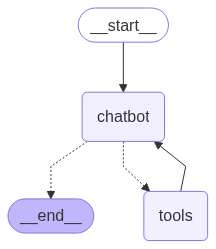

In [17]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Probamos

In [ ]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


### Memoria

En el ejercicio anterior no hemos implementado la memoria del grafo. Por ejemplo, si en la interacción le da al LLM su nombre y luego se lo pregunta, el LLM no lo recordará. Se podría haber hecho invocando simplemente así:

```python
graph.invoke({"messages": history + [{"role": "user", "content": user_input}]})
```

Pero, haciéndolo así, no estaríamos aprovechando los estados de LangChain.

La memoria en LangChain se implementa mediante `checkpointing`. En este caso, vamos a crear una memoria en memoria (valga la redundancia).

In [31]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Asociamos la memoria al construir el grafo

In [32]:
graph = graph_builder.compile(checkpointer=memory)

Creamos un objeto de configuración para asociar la memoria a una conversación (nos inventamos un id)

In [33]:
config = {"configurable": {"thread_id": "1"}}


Probamos pasando el objeto config

In [35]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


Podemos ver el estado de la conversación

In [24]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hola me llamo Pepe', additional_kwargs={}, response_metadata={}, id='07a9e750-3bf6-4120-97c6-391b10bbd9d2'), AIMessage(content='Hola Pepe, ¿cómo puedo ayudarte hoy?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--21af6c8b-7ba9-4354-ad95-fa0b46432d10-0', usage_metadata={'input_tokens': 49, 'output_tokens': 10, 'total_tokens': 59, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Dime cómo me llamo', additional_kwargs={}, response_metadata={}, id='44b1ecfd-fea9-4023-8bbc-17f1b1d78dee'), AIMessage(content='Te llamas Pepe.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--aee5f131-7d89-4f9a-ac02-cda88709f315-0', usage_metadata={'

También lo podemos ver paso a paso. Cada vez que se completa el grafo se almacena un `snapshot`.

In [25]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hola me llamo Pepe', additional_kwargs={}, response_metadata={}, id='07a9e750-3bf6-4120-97c6-391b10bbd9d2'), AIMessage(content='Hola Pepe, ¿cómo puedo ayudarte hoy?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--21af6c8b-7ba9-4354-ad95-fa0b46432d10-0', usage_metadata={'input_tokens': 49, 'output_tokens': 10, 'total_tokens': 59, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Dime cómo me llamo', additional_kwargs={}, response_metadata={}, id='44b1ecfd-fea9-4023-8bbc-17f1b1d78dee'), AIMessage(content='Te llamas Pepe.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--aee5f131-7d89-4f9a-ac02-cda88709f315-0', usage_metadata={

LangGraph permite retrotraer la conversación al momento deseado:

```python
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```
